# Setting up DATA

In [19]:
import os
import pandas as pd
import geopandas as gpd
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')
import datetime as dtm

RANDOM_SEED = 20190320

In [81]:
mcity_df = pd.read_csv('data/climate_change/GlobalLandTemperaturesByMajorCity.csv')
print("Shape of this dataframe is {0}".format(mcity_df.shape))
mcity_df.head()

Shape of this dataframe is (239177, 7)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [82]:
mcity_df.dt = pd.to_datetime(mcity_df.dt, errors='coerce')
mcity_df['Latitude'] = mcity_df.Latitude.apply(lambda x: float(x.split('N')[0]) if 'N' in x else -float(x.split('S')[0]))
mcity_df['Longitude'] = mcity_df.Longitude.apply(lambda x: float(x.split('E')[0]) if 'E' in x else -float(x.split('W')[0]))
print(mcity_df.dtypes)
mcity_df.head()

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                float64
Longitude                               float64
dtype: object


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01 00:00:00,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23
1,1849-02-01 00:00:00,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23
2,1849-03-01 00:00:00,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23
3,1849-04-01 00:00:00,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23
4,1849-05-01 00:00:00,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23


In [83]:
print(max(mcity_df.dt), min(mcity_df.dt))
mcity_df = mcity_df[(mcity_df.dt >= '1900-01-01') & (mcity_df.dt <= '2010-12-01')]
print("Shape of dataframe after filtering for 20th century onwards {0}".format(mcity_df.shape))

(Timestamp('2013-09-01 00:00:00'), Timestamp('1743-11-01 00:00:00'))
Shape of dataframe after filtering for 20th century onwards (133200, 7)


In [84]:
print("Number of major cities {0}".format(mcity_df.City.nunique()))

Number of major cities 100


In [85]:
mcity_df['year'] = mcity_df.dt.dt.year
mcity_df['month'] = mcity_df.dt.dt.month
mcity_df = mcity_df.drop('dt', axis=1)
mcity_df.head()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
612,25.696,1.326,Abidjan,Côte D'Ivoire,5.63,-3.23,1900,1
613,27.816,0.789,Abidjan,Côte D'Ivoire,5.63,-3.23,1900,2
614,28.395,1.296,Abidjan,Côte D'Ivoire,5.63,-3.23,1900,3
615,27.706,0.501,Abidjan,Côte D'Ivoire,5.63,-3.23,1900,4
616,26.753,0.458,Abidjan,Côte D'Ivoire,5.63,-3.23,1900,5


In [86]:

def find_diff(row):
    if row.year > 1900:
        tempdf = mcity_df[(mcity_df.year==row.year-1) & (mcity_df.month==row.month) & (mcity_df.City==row.City)]
        temperature_diff = row['AverageTemperature'] - tempdf.loc[list(tempdf.index)[0]]['AverageTemperature']
        return temperature_diff
    return 0

mcity_df['temp_diff'] = mcity_df.apply(lambda x: find_diff(x), axis=1)

In [87]:
mcity_df[(mcity_df.City=='New York') & (mcity_df.month==1)].head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,temp_diff
171643,-2.214,0.450,New York,United States,40.99,-74.56,1900,1,0.000
171655,-2.607,0.485,New York,United States,40.99,-74.56,1901,1,-0.393
171667,-4.177,0.680,New York,United States,40.99,-74.56,1902,1,-1.570
171679,-3.261,0.615,New York,United States,40.99,-74.56,1903,1,0.916
171691,-7.506,0.747,New York,United States,40.99,-74.56,1904,1,-4.245


# Hypothesis Testing - Comparing Two groups with Continuous Outcome

Null hypothesis: Average temperatures have not increased from the year 1900 compared to 2013 for major cities in the world

Rejection of null hypothesis occurs when chosen test statistic is higher than some pre-specified threshold value; non-rejection occurs otherwise.

Problem is there is so much subjectivity in this process. What test(t-test, chi-squared etc.) to perform. What p-value to use? 

# Bayesian Inference

Instead of hypothesist testing, use bayesian inference to estimate how different the two groups and are provide the confidence of estimating the difference
All conclusions from Bayesian statistical procedures in terms of probability statements
         p (theta | y)
      theta - unknowns; y - observations
1. ease of interpretation
2. incorporate uncertainity
3. Easy to calculte summary

               P( theta | y) = P(theta) * P( y | theta) / p(y)
                                  |            |          |
                                 Prior      Likelihood   Normalizing constant
                  

Calculating Normalizing constant was very difficult back then which is why Bayesian Statistics had taken a backseat
But now, thanks to available hardware, Bayesian Stats is becoming popular

Process of conducting Bayesian Statistical analysis involves 3 steps
1. Specify a probability model - unknown parameters, data, covariates, etc. All must be assigned some probability density
2. Calculate posterior distribution (Not possible anaytically. So packages like pymc3 does approximations for us)
3. Check your model for fit

# Estimation for one group

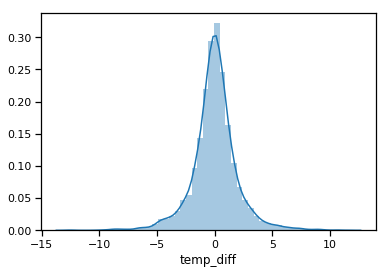

In [101]:
nhem_jan_mcity_df = mcity_df[(mcity_df.month==12) & (mcity_df.Latitude > 0)]
sns.distplot(nhem_jan_mcity_df.temp_diff)

# Questions to ask are
1. Are the major cities having temperature variability higher than a threshold in the weather pattern?
2. What is the probability that any randomly chosen year has high temperature increase greater than a threshold?

# Step 1
Data looks like a Normal distribution

\begin{align}
y_{i} = N(\mu, \sigma^{2})
\end{align}

We need to build two priors. One is $\mu$ and other is $\sigma$

$\mu$ = _N_(0, 10$^{2}$)

$\sigma$ = _N_(0, 10$^{2}$)


In [118]:
from pymc3 import Model, Uniform, Normal

with Model() as climate_model:
    mu = Normal('mu', sd = 10)
    sigma = Normal('sigma', sd=10)
#     sigma = Uniform('sigma', 0, 10)

In [119]:
with climate_model:
    y = Normal('y', mu=mu, sd=sigma, observed=mcity_df.temp_diff)

Now we will fit the model using an approach called Variational Inference. This will estimate the posterior distribution using an optimized approximation, and then draw samples from it.

In [120]:
from pymc3 import fit
with climate_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = inf: 100%|██████████| 10000/10000 [00:19<00:00, 509.07it/s]      
Finished [100%]: Average Loss = 3.7151e+05


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03feb51d50>,
      dtype=object)

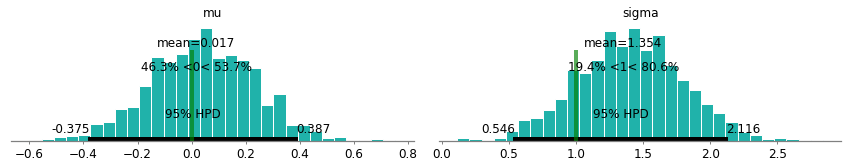

In [121]:
from pymc3 import plot_posterior

plot_posterior(samples, varnames=['mu', 'sigma'], ref_val=[0, 1], color='LightSeaGreen')

What does the above graph say?

From the first graph, there is a higher chance that the major cities of the earth are warming up.

From the second graph, which is what we are more interested in, we decided the threshold for sigma=1 is fine. We are 80.6% certain that the annual temperature variations are > 1 -> Unpredictable weather

So to sum, the major cities are warming up with high unpredictability

In [122]:
mus = samples['mu']
sigmas = samples['sigma']
climate_samples = Normal.dist(mus, sigmas).random()
(climate_samples>0.1).mean()

0.479

There is almost half a chance that a year is going to be warmer by 0.1 celsius

# Model Checking - Posterior Predictive Checks

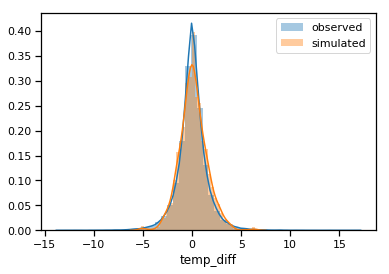

In [123]:
sns.distplot(mcity_df.temp_diff, label='observed')
sns.distplot(climate_samples, label='simulated')
plt.legend()

# Prior Sensitivity

In [124]:
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    mu = Flat('mu')
    sigma = HalfCauchy('sigma', 5)
    
    y = Normal('y', mu=mu, sd=sigma, observed=mcity_df.temp_diff)
    sensitivity_samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 2.4994e+05: 100%|██████████| 10000/10000 [00:19<00:00, 508.14it/s]
Finished [100%]: Average Loss = 2.4994e+05


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03e5a5d810>,
      dtype=object)

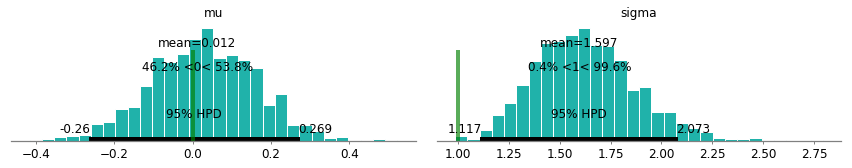

In [125]:
plot_posterior(sensitivity_samples, varnames=['mu', 'sigma'], ref_val=[0, 1], color='LightSeaGreen')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03e45e9f50>,
      dtype=object)

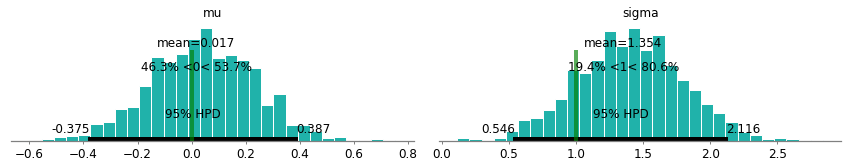

In [126]:
plot_posterior(samples, varnames=['mu', 'sigma'], ref_val=[0, 1], color='LightSeaGreen')

# Two continous groups

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03e284f9d0>,
      dtype=object)

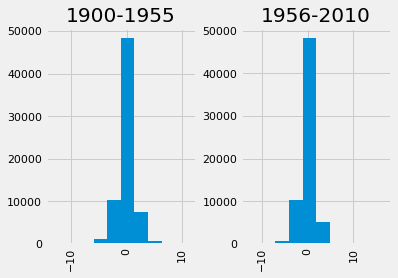

In [130]:
plt.style.use('fivethirtyeight')
first_half_temp = pd.DataFrame(dict(temp_diff=(mcity_df[mcity_df.year <= 1956].temp_diff), group='1900-1955'))
second_half_temp = pd.DataFrame(dict(temp_diff=(mcity_df[mcity_df.year > 1956].temp_diff), group='1956-2010'))
complete_data = pd.concat([first_half_temp, second_half_temp], ignore_index=True)
complete_data.hist('temp_diff', by='group')

(-10, 10)

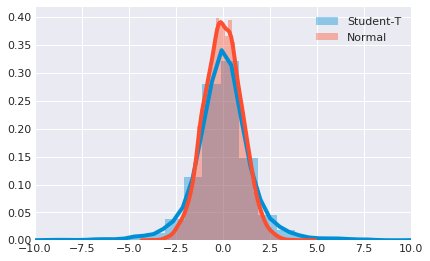

In [134]:
from pymc3 import StudentT

t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0, 1).random(size=10000)

sns.distplot(t, label='Student-T')
sns.distplot(n, label='Normal')
plt.legend()
plt.xlim([-10, 10])

In [136]:
from pymc3 import Exponential

with Model() as century_model:
    mu_0 = Normal('mu_0', 0, 10)
    mu_1 = Normal('mu_1', 0, 10)
    
    sigma_0 = Uniform('sigma_0', lower=0, upper=10)
    sigma_1 = Uniform('sigma_1', lower=0, upper=10)
    
    nu = Exponential('nu', 1/30.) + 1
    
    first_half = StudentT('first_half', nu=nu, mu=mu_0, lam=sigma_0**-2, observed=first_half_temp.temp_diff)
    second_half = StudentT('second_half', nu=nu, mu=mu_1, lam=sigma_1**-2, observed=second_half_temp.temp_diff)

Now that model is specified, we want to find a metric of interest which is the difference in means between the first half of century difference in temperatures and second half of century difference in temperatures.

We will estimate the 'effect size', which is the difference in means scaled by the pooled estimated of standard deviation.

In [138]:
from pymc3 import Deterministic

with century_model:
    diff_of_means = Deterministic('difference of means', mu_1 - mu_0)
    
    effect_size = Deterministic('effect size', diff_of_means/np.sqrt((sigma_1**2 + sigma_0**2)/2))

In [139]:
with century_model:
    century_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 2.4472e+05: 100%|██████████| 10000/10000 [00:46<00:00, 215.21it/s]
Finished [100%]: Average Loss = 2.4469e+05


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03deedea10>,
      dtype=object)

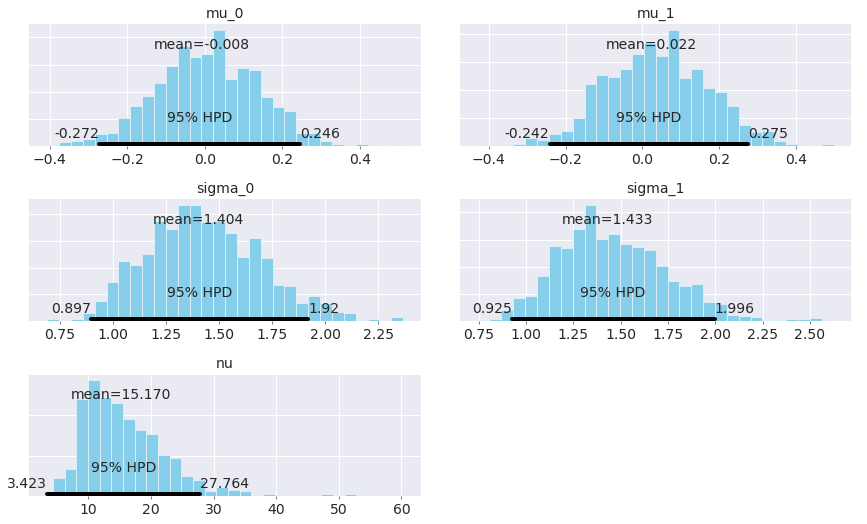

In [140]:
plot_posterior(century_trace, varnames=['mu_0', 'mu_1', 'sigma_0', 'sigma_1', 'nu'], color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03deb0cd50>,
      dtype=object)

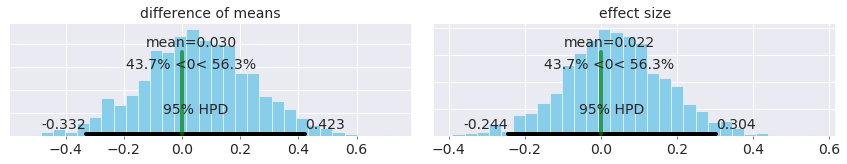

In [141]:
plot_posterior(century_trace, varnames=['difference of means', 'effect size'], ref_val = 0, color='#87ceeb')

The posterior probability that the second half of the century is warming faster than the first half is 0.563

# Quick comparison of Winter versus Summer

In [153]:
winter_temp_diff = mcity_df[(mcity_df.month==1) | (mcity_df.month==12)].temp_diff
summer_temp_diff = mcity_df[(mcity_df.month==6) | (mcity_df.month==5)].temp_diff

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03dcf15190>,
      dtype=object)

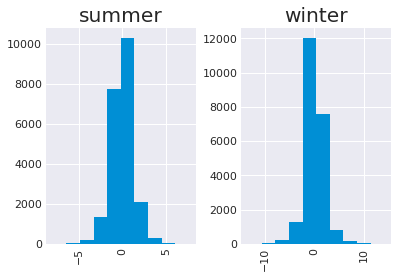

In [159]:
pd.concat([pd.DataFrame(dict(temp_diff=winter_temp_diff, group='winter')), 
           pd.DataFrame(dict(temp_diff=summer_temp_diff, group='summer'))]).hist('temp_diff', by='group')

In [181]:
from pymc3 import Gamma

with Model() as season_model:
    sigma = Uniform('sigma_sum', 0, 5)
    mu_win = Normal('mu_win', 0, 10)
    mu_sum = Normal('mu_sum', 0, 5)
    
    winter = Normal('winter', mu=mu_win, sd=sigma, observed=winter_temp_diff)
    summer = Normal('summer', mu=mu_sum, sd=sigma, observed=summer_temp_diff)
    
    d = Deterministic('d', (mu_sum-mu_win))

In [182]:
with season_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 85,718: 100%|██████████| 10000/10000 [00:09<00:00, 1054.96it/s]
Finished [100%]: Average Loss = 85,716


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03ecd6f050>,
      dtype=object)

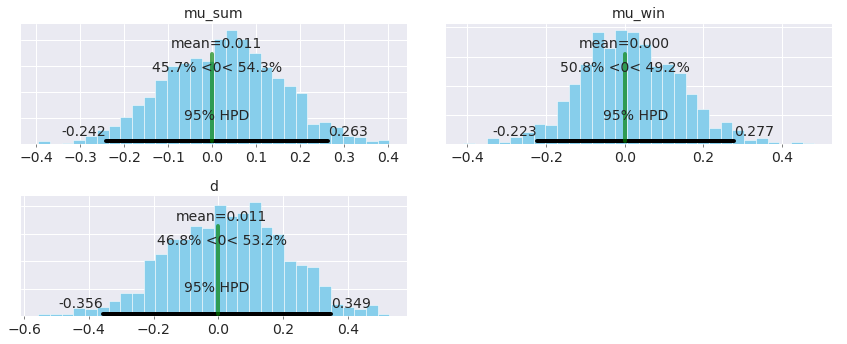

In [183]:
plot_posterior(samples, varnames=['mu_sum', 'mu_win', 'd'], ref_val=0)